# Sam Klebanof - TFCB 2020 Capston - Python

## Questions 2/3: False positives vs false negatives

The first question I will address in this iPython notebook is as follows:

In the dataset provided by the authors, are there more patients whose measurements would cause them to be falsely diagnosed with glaucoma, or falsely diagnosed as healthy?

More specifically, I will be modeling the data using the authors' C5.0 decision-tree-based machine learning algorithm. This decision tree will call each data point as glaucoma-positive or healthy. Then I will quantify how many data points from actual glaucoma-positive samples fall into the 'healthy' group, and vice versa. This is a very clinically relevant question for this particular dataset, as the authors' main goal is to use this data to generate a glaucoma-diagnosing algorithm. And, in medical diagnoses, false positives and false negatives are not created equal. In the case of a false positive, further testing would likely reveal that patient did not in fact have glaucoma, however in the case of a false negative, a patient's glaucoma could be allowed to continue progressing and cause more damage before being treated.

In [1]:
# Recreate the authors' final C5.0 decision-tree-based machine learning model. The authors
# don't include the code that was used to generate this model, however they do publish the
# model itself, which is a simple decision tree. This decision tree can be recreated as a
# series of nested for loops, reutrning either 0 (healthy) or 1 (glaucoma-positive) for each
# data point
def C5_decision_tree_model_fit(age, OP, MD, PSD, GHT, CT, RNFL):
    """
    Predict whether a set of clinical measurements should be diagnosed as 
    glaucoma-positive or healthy.
    
    Parameters
    -----------
    age: Age of the patient
    OP: Ocular pressure
    MD: Mean deviation
    PSD: Pattern standard deviation
    GHT: Glaucoma hemifield test score
    CT: Cornea thickness
    RNFL: Average value of RNFL SUP, INF, and TMP
        
    Returns
    -------
    int
        Either 0, if the patient is predicted to be healthy, or 1, if the 
        patient is predicted to be glaucoma-positive.

    Example
    --------
    >>> C5_decision_tree_model_fit(62, 17, -0.54, 1.81, 0, 558, 103.3333)
    '0'
    """
    if RNFL <= 89.33334:
        if MD <= -4.02:
            return(1)
        elif MD > -4.02:
            if age > 77:
                return(0)
            elif age <= 77:
                if OP > 23:
                    return(1)
                if OP <= 23:
                    if CT > 580:
                        return(0)
                    elif CT <= 580:
                        if PSD > 2.14:
                            return(1)
                        elif PSD <= 2.14:
                            if MD <= -1.82:
                                return(1)
                            elif MD > -1.82:
                                return(0)
    elif RNFL > 89.33334:
        if PSD > 6.15:
            return(1)
        elif PSD <= 6.15:
            if OP > 23:
                if PSD <= 2.37:
                    return(0)
                elif PSD > 2.37:
                    return(1)
            elif OP <= 23:
                if RNFL > 101.6667:
                    return(0)
                elif RNFL <= 101.6667:
                    if age <= 63:
                        if RNFL > 91.33334:
                            return(0)
                        elif RNFL <= 91.33334:
                            if age <= 41:    
                                return(1)
                            elif age > 41:    
                                return(0)
                    elif age > 63:
                        if CT <= 522:
                            return(0)
                        elif CT > 522:
                            if OP > 19:  
                                return(0)
                            elif OP <= 19: 
                                if GHT <= 1:  
                                    return(1)
                                elif GHT > 1:  
                                    if OP <= 540:  
                                        return(1)
                                    elif OP > 540:  
                                        return(0)

In [9]:
import pandas as pd

# Import the data into a pandas dataframe. We will use the entire dataset for this question.
data = pd.read_csv('data/ds_whole.csv')

# Capture the actual glaucoma measurements into a list to compare against the model
glaucoma = list(data["glaucoma"])

# Use the above function to create a list of glaucoma predictions for each row in the
# original 'data' dataframe. The index of this list will match the order of the points
# in the dataframe, as well as the order of the 'glaucoma' actual measurements dataframe
glaucoma_calls = []
for i in data.index:
    glaucoma_calls.append(
        C5_decision_tree_model_fit(
            age = data["age"][i],
            OP = data["ocular_pressure"][i],
            MD = data["MD"][i],
            PSD = data["PSD"][i],
            GHT = data["GHT"][i],
            CT = data["cornea_thickness"][i],
            RNFL = data["RNFL4.mean"][i]
        )
    )

# Count the number of false negatives and false positives
false_positives = 0
false_negatives = 0
for actual, predicted in zip(glaucoma, glaucoma_calls):
    if actual == 0 and predicted == 1:
        false_positives += 1
    elif actual == 1 and predicted == 0:
        false_negatives += 1

So far, I have created a function that allows the authors' final machine learning model to be used in this notebook. I then imported the entire dataset (since this model should theoretically apply to any set of clinical measurements, I made no distinction between test/training data here). After that, I went through each line of the dataset, used the model to predict whether the patient had glaucoma, and tallied up the total numbers of false positives and false negatives. The last thing I will do is visualize the data by differentially coloring each type of data point and plotting them on a PCA plot.

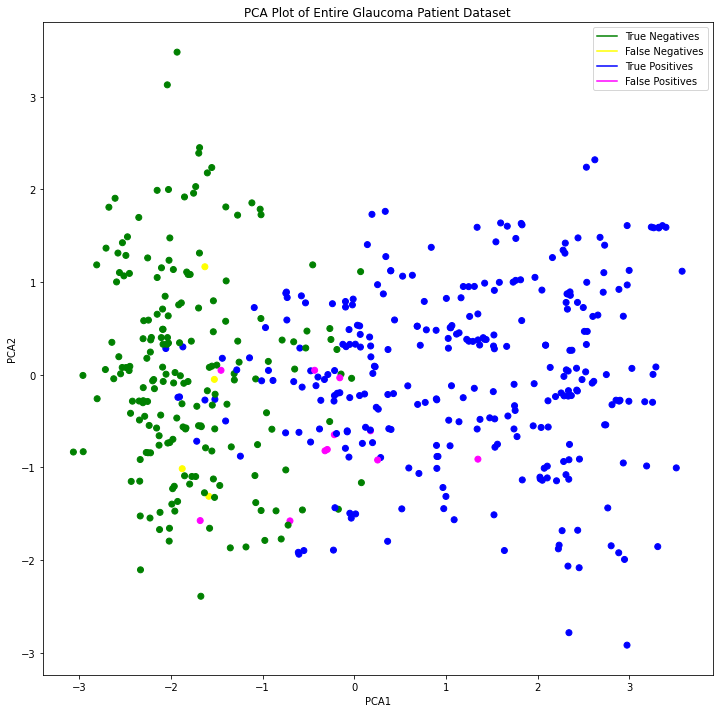

The total number of false negatives in this dataset is 4, the number of false positives is 11


In [10]:
# Trim the data for use in the PCA algorithm. Remove RL as it is not a relevant variable 
# for this analysis. Remove glaucoma as we eventually want the data to cluster into 
# +/- glaucoma, which we will then compare against the actual glaucoma measurement.
X_data = data.drop(columns = ["RL", "glaucoma"])

# Import the sklearn tools we'll need
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scale the data for a more accurate PCA plot
scaler = StandardScaler()
scaler.fit(X_data)
X_data_scaled = scaler.transform(X_data)

# Create a 7-component PCA
pca = PCA(n_components=7)
pca.fit(X_data_scaled)
X_pca = pca.transform(X_data_scaled)

# For each data point, assign an identity value corresponding to true negative ('TN'), 
# true positive ('TP'), false negative ('FN'), or false positive ('FP')
data_identity = []
for i in data.index:
    if glaucoma_calls[i] == 0:
        if glaucoma[i] == glaucoma_calls[i]:
            data_identity.append('TN')
        elif glaucoma[i] != glaucoma_calls[i]:
            data_identity.append('FN')
    elif glaucoma_calls[i] == 1:
        if glaucoma[i] == glaucoma_calls[i]:
            data_identity.append('TP')
        elif glaucoma[i] != glaucoma_calls[i]:
            data_identity.append('FP')

# Map each type of identity to a different color for plotting purposes
identity_to_color = {'TN':'green', 'FN':'yellow', 'TP':'blue', 'FP': 'magenta'}
colors = []
for identity in data_identity:
    colors.append(identity_to_color[identity])

# Plot the data using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.scatter(X_pca[:,0], X_pca[:,1], c=colors)
plt.title('PCA Plot of Entire Glaucoma Patient Dataset')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.plot([],[],'green',label="True Negatives")
plt.plot([],[],'yellow',label="False Negatives")
plt.plot([],[],'blue',label="True Positives")
plt.plot([],[],'magenta',label="False Positives")
plt.legend()
plt.savefig('figures/Q2_false_positives_vs_false_negatives')
plt.show();

print(f'The total number of false negatives in this dataset is {false_negatives}, ' +
      f'the number of false positives is {false_positives}')

The result of this analysis shows that the authors' machine learning model outputs 2.75 times as many false positives as false negatives for this dataset. As stated above, false negatives can be much more harmful to the patient than false positives, so this trend of the model is good to see. It's also interesting to note that the placement of the false negatives/positives on the PCA plot follow different patterns. While the false negatives are all much further to the left than most of the true positives (the group to which they would belong if the model were perfect), the false positives are a bit more evenly disperesed throughout the true negatives. Lastly, it's worth noting that since there were 499 patients represented in this dataset, the false positive rate is 11/499 = 2.2%, while the false negative rate is 4/499 = 0.8%. This might be useful information to a doctor deciding whether to adopt this model as a diagnostic program for glaucoma.

## Variables influencing mis-identification

The final question I will ask of this dataset is:

Within the false positives/negatives, which variables contribute most to the mis-identification of that patient?

Specifically, I will compare the values of each variable for the false positive and false negative groups to the mean and standard deviation of that variable in the true negative and true positive groups. For the false negative group, I'll identify which variable(s) are most different from the average glaucoma-positive patient, and vice versa. This information could theoretically be used to exlcude some data from the dataset if one's goal were to minimize false negatives or positives. The variables identified may also be of some clinical relevance.

In [36]:
import numpy as np

# First, add the data_identity list as a column into the 'data' dataframe
data["identity"] = data_identity

# Separate out the false negative and false positive data points into new
# dataframes, then separate out all the glaucoma positive and healthy 
# data points as well
FN_list = data.loc[data["identity"] == 'FN']
FP_list = data.loc[data["identity"] == 'FP']
glaucoma_list = data.loc[data["glaucoma"] == 1]
healthy_list = data.loc[data["glaucoma"] == 0]

# Create a list of all the numeric variables which can be looped over
variable_list = ['age', 'ocular_pressure', 'MD', 'PSD', 'GHT', 'cornea_thickness', 'RNFL4.mean']

# For the false negative group, find the average of each variable and compare
# it to the average and standard deviation of that variable in the glaucoma-
# positive group. The final comparison value I will use is the standardized
# difference from glaucoma-positive to false negative
FN_comparison = []
for str in variable_list:
    FN_comparison.append(
        (np.mean(FN_list[str]) - np.mean(glaucoma_list[str]))/np.std(glaucoma_list[str])
    )
    
# Do the same thing for the false positives
FP_comparison = []
for str in variable_list:
    FP_comparison.append(
        (np.mean(FP_list[str]) - np.mean(healthy_list[str]))/np.std(healthy_list[str])
    )

To answer this question, I've split the data up into four separate data frames: the false negatives (patients who had glaucoma but for whom the model predicts they're healthy), the false positives (healthy patients who are predicted to have glaucoma), all truly glaucoma-positive patients (regardless of prediction), and all truly healthy patients. The metric that I will use to determine which variables contribute most to misidentification is as follows:

After taking the mean of the false group, and the mean and standard deviation of the true group,

Standardized change = (mean_of_false - mean_of_true) / standard_deviation_of_true

Finally, I will create two tables to show the standardized change for every variable, for both the false negatives and false positives. I will end by showing a graphical comparison of some of the variables which are most changed between false and true groups.

╒═══════════════════╤═══════╤═══════════════════╤══════╤═══════╤═══════╤════════════════════╤════════╕
│ False Negatives   │   Age │   Ocular Pressure │   MD │   PSD │   GHT │   Cornea Thickness │   RNFL │
╞═══════════════════╪═══════╪═══════════════════╪══════╪═══════╪═══════╪════════════════════╪════════╡
│ Standard Change:  │ -0.46 │             -0.75 │ 0.97 │ -1.44 │ -2.53 │               0.62 │   1.52 │
╘═══════════════════╧═══════╧═══════════════════╧══════╧═══════╧═══════╧════════════════════╧════════╛
╒═══════════════════╤═══════╤═══════════════════╤═══════╤═══════╤═══════╤════════════════════╤════════╕
│ False Positives   │   Age │   Ocular Pressure │    MD │   PSD │   GHT │   Cornea Thickness │   RNFL │
╞═══════════════════╪═══════╪═══════════════════╪═══════╪═══════╪═══════╪════════════════════╪════════╡
│ Standard Change:  │  1.14 │             -0.02 │ -1.38 │  1.65 │  1.39 │               0.29 │  -1.27 │
╘═══════════════════╧═══════╧═══════════════════╧═══════╧═══════╧════

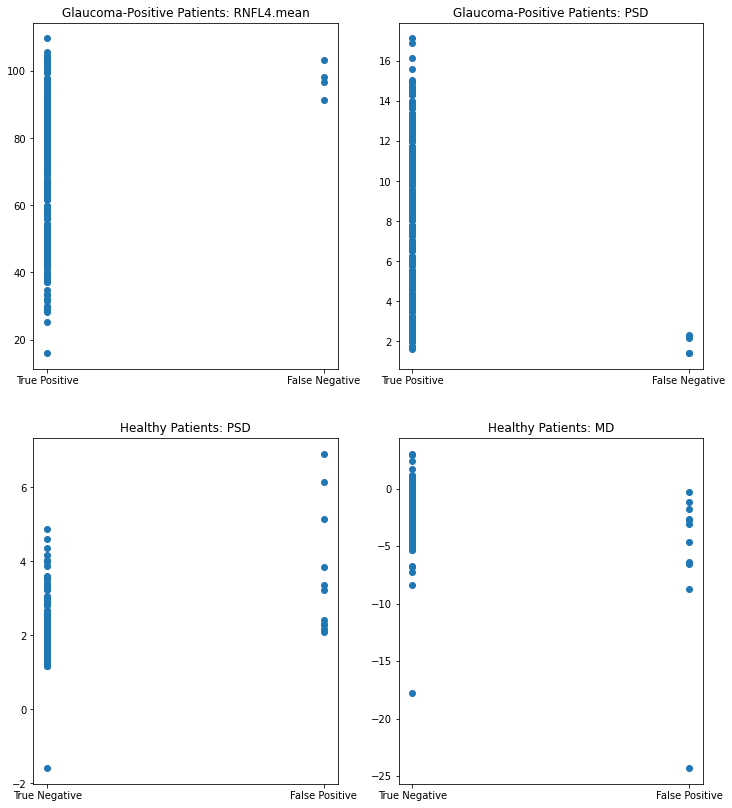

In [68]:
# I will use the 'tabulate' package to make tables
from tabulate import tabulate

# Prepare the data for presentation - round the standardized changes to the 
# nearest hundredth, capitalize the variable names, add a new entry at the
# beginning of each list to make a new first column
FN_comp_rounded = [round(i,2) for i in FN_comparison]
rowN = ['Standard Change:']
rowN.extend(FN_comp_rounded)

FP_comp_rounded = [round(i,2) for i in FP_comparison]
rowP = ['Standard Change:']
rowP.extend(FP_comp_rounded)

column_titles_N = ['False Negatives', 'Age', 'Ocular Pressure', 'MD', 'PSD', 'GHT', 'Cornea Thickness', 'RNFL']
column_titles_P = ['False Positives', 'Age', 'Ocular Pressure', 'MD', 'PSD', 'GHT', 'Cornea Thickness', 'RNFL']

# Print the tables
n = [rowN]
table_n = tabulate(n, headers = column_titles_N, tablefmt='fancy_grid')
p = [rowP]
table_p = tabulate(p, headers = column_titles_P, tablefmt='fancy_grid')
print(table_n)
print(table_p)


# Prepare the data for graphing - change 'FN' to 'False Negative', etc
expand_data = data.copy()
for i in data.index:
    if data["identity"][i] == 'FN':
        expand_data["identity"][i] = 'False Negative'
    if data["identity"][i] == 'FP':
        expand_data["identity"][i] = 'False Positive'
    if data["identity"][i] == 'TN':
        expand_data["identity"][i] = 'True Negative'
    if data["identity"][i] == 'TP':
        expand_data["identity"][i] = 'True Positive'

g_plot = expand_data.loc[expand_data["glaucoma"] == 1]
h_plot = expand_data.loc[expand_data["glaucoma"] == 0]

# Make the plots
plt.figure(figsize=(12,14))

plt.subplot(2, 2, 1)
plt.scatter(g_plot["identity"], g_plot["RNFL4.mean"])
plt.title('Glaucoma-Positive Patients: RNFL4.mean')

plt.subplot(2, 2, 2)
plt.scatter(g_plot["identity"], g_plot["PSD"])
plt.title('Glaucoma-Positive Patients: PSD');

plt.subplot(2, 2, 3)
plt.scatter(h_plot["identity"], h_plot["PSD"])
plt.title('Healthy Patients: PSD')

plt.subplot(2, 2, 4)
plt.scatter(h_plot["identity"], h_plot["MD"])
plt.title('Healthy Patients: MD');

plt.savefig('figures/Q3_variable_differences_between_groups')

*As a caveat, I chose not to graph GHT even though it had the highest or second-highest standard change for both groups. This is because GHT can only have a value of 1, 0, or -1, which makes it very hard to interpret on a scatter plot*

<br />

The result of this analysis shows that for the glaucoma-positive patients who were incorrectly identified as healthy (the false negatives), the variable which was most different from the glaucoma-positive average was GHT, followed by RNFL, PSD, MD, Ocular Pressure, Cornea Thickness, and lastly, Age.

For the healthy patients incorrectly called as glaucoma-positive (false positives), the variable which was most different from the healthy average was PSD, followed by GHT, MD, RNFL, Age, Cornea Thickness, and lastly, Ocular Pressure.

Based on the above scatter plots, even the most different variables between true and false groups seem to be within the same range of one another. For the false negative group, both RNFL4.mean and PSD simply fall on the extreme end of the range of normal glaucoma-psotive data. For the false positive group, the difference in average PSD and average MD seems to mostly come down to outliers, with the bulk of data points falling in the same place.

I do not have nearly enough knowledge of glaucoma or these particular clinical eye measurements to say with any certainty whether the variables identified here make sense to be the ones contributing most to mis-identification. However, it's also worth considering that are at least four variables for both false negatives and positives that are ~1 standard deviation or more away from the average of their true population. If I were a clinician using this model to predict if my patient had glaucoma, and the model gave a glaucoma-negative diagnosis, I may want to check if the measurements used had greater than the healthy average MD, lower than the healthy average PSD, lower than the healthy average GHT, and higher than the healthy average RNFL4.mean. If that were the case, I would be much more wary that the diagnosis might be a false negative.